<a href="https://colab.research.google.com/github/NikNord174/Autoencoder/blob/main/Autoencoder_new%20models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [1]:
import os
import sys

from time import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Normalize


In [2]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 28.6 MB/s 


In [3]:
from ignite.metrics import SSIM

In [ ]:
help(SSIM)

In [63]:
# With square kernels and equal stride
filters = torch.randn(9, 4, 3, 3)
inputs = torch.randn(1, 4, 5, 5)
F.conv2d(inputs, filters, padding=1, groups=3).size()

RuntimeError: ignored

In [5]:
BATCH_SIZE = 64
NUM_WORKERS = 2
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')


In [6]:
transform=transforms.Compose([
                              ToTensor(),
                              Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
train = datasets.CIFAR10('../data',
                         train=True,
                         download=True,
                         transform=transform)
test = datasets.CIFAR10('../data',
                        train=False,
                        download=True,
                        transform=transform)
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


## Models

### Autoencoder_ConvTranspose

In [10]:
class Autoencoder_ConvTranspose(nn.Module):
    def __init__(self):
        super(Autoencoder_ConvTranspose, self).__init__()
        self.channels = [3, 100, 200, 300]
        self.encoder = self.encoder_layers()
        self.decoder = self.decoder_layers()

    def simple_enc_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 3,
                         final_layer: bool = False) -> nn.Sequential:
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=kernel_size,
                ),
                nn.BatchNorm2d(output_channels),
                nn.MaxPool2d(kernel_size=3),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
                )
        else:
            return nn.Sequential(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=300,
                    kernel_size=2,
                ),
                )

    def encoder_layers(self) -> nn.Sequential:
        layers = []
        for i in range(len(self.channels)-1):
            if self.channels[i] != self.channels[-2]:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1])
                )
            else:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1],
                    final_layer=True)
                )
        return nn.Sequential(*layers)

    def simple_dec_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 3,
                         stride=2,
                         dilation=2,
                         output_padding=1,
                         final_layer: bool = False) -> nn.Sequential:
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   dilation=dilation,
                                   output_padding=output_padding,),
                nn.BatchNorm2d(output_channels),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
                )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=3,
                                   stride=stride,
                                   dilation=1,
                                   padding=1,
                                   output_padding=1)
                )

    def decoder_layers(self) -> nn.Sequential:
        layers = []
        dec_channels = list(reversed(self.channels))
        for i in range(len(dec_channels)-1):
            if dec_channels[i] != dec_channels[-2]:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1])
                )
            else:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1],
                    final_layer=True)
                )
        return nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Autoencoder_Upsamling

In [10]:
class Autoencoder_Upsampling(nn.Module):
    def __init__(self):
        super(Autoencoder_Upsampling, self).__init__()
        self.channels = [3, 100, 200, 300]
        self.encoder = self.encoder_layers()
        self.decoder = self.decoder_layers()

    def simple_enc_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 3,
                         final_layer: bool = False) -> nn.Sequential:
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=kernel_size,
                ),
                nn.BatchNorm2d(output_channels),
                nn.MaxPool2d(kernel_size=3),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
                )
        else:
            return nn.Sequential(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=300,
                    kernel_size=2,
                ),
                )

    def encoder_layers(self) -> nn.Sequential:
        layers = []
        for i in range(len(self.channels)-1):
            if self.channels[i] != self.channels[-2]:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1])
                )
            else:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1],
                    final_layer=True)
                )
        return nn.Sequential(*layers)

    def simple_dec_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 1,
                         scale_factor=4,
                         final_layer: bool = False) -> nn.Sequential:
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=kernel_size,
                ),
                nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
                #nn.BatchNorm2d(output_channels),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
                )
        else:
            return nn.Sequential(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=kernel_size,
                ),
                nn.Upsample(scale_factor=2, mode='bilinear'),
                )

    def decoder_layers(self) -> nn.Sequential:
        layers = []
        dec_channels = list(reversed(self.channels))
        for i in range(len(dec_channels)-1):
            if dec_channels[i] != dec_channels[-2]:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1])
                )
            else:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1],
                    final_layer=True)
                )
        return nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Losses

In [57]:
def MSE(fake: torch.Tensor,
        image: torch.Tensor) -> torch.Tensor:
    return torch.mean((fake - image)**2)


def SSIM(fake: torch.Tensor, real: torch.Tensor) -> torch.Tensor:
    k1: float = 0.01
    k2: float = 0.03
    mean_fake = torch.mean(fake, dim=[1, 2, 3])
    mean_real = torch.mean(real, dim=[1, 2, 3])
    var_fake = torch.var(fake, dim=[1, 2, 3])
    var_real = torch.var(real, dim=[1, 2, 3])
    c1 = (k1) ** 2  # L=1, тк изображения нормализованы
    c2 = (k2) ** 2  # L=1, тк изображения нормализованы
    fake_dif = torch.sub(fake, mean_fake[:, None, None, None])
    real_dif = torch.sub(real, mean_real[:, None, None, None])
    covariance = (
        torch.sum(fake_dif * real_dif, dim=[1, 2, 3])
        / real.size()[-1] / real.size()[-2] / real.size()[-3]
    )
    ssim_numerator = (
        (2 * mean_fake * mean_real + c1) * (2 * covariance + c2)
    )
    ssim_denominator = (
        ((mean_fake) ** 2 + (mean_real) ** 2 + c1)
        * ((var_fake) ** 2 + (var_real) ** 2 + c2)
    )
    ssim = ssim_numerator / ssim_denominator
    print('mean_fake:', torch.mean(mean_fake))
    print('mean_real:', torch.mean(mean_real))
    print('var_fake:', torch.mean(var_fake))
    print('var_real:', torch.mean(var_real))
    print('fake_dif:', fake_dif.size())
    print('real_dif:', torch.mean(real_dif))
    print('covariance size:', covariance.size())
    print('covariance:', torch.mean(covariance))
    print('ssim_numerator:', torch.mean(ssim_numerator))
    print('ssim_denominator:', torch.mean(ssim_denominator))
    print('ssim:', torch.mean(ssim))
    return torch.mean(ssim)


In [58]:
fake = torch.randn(64, 3, 32, 32)
real = torch.randn(64, 3, 32, 32)
SSIM(fake, real)

mean_fake: tensor(-0.0011)
mean_real: tensor(0.0005)
var_fake: tensor(0.9949)
var_real: tensor(1.0036)
fake_dif: torch.Size([64, 3, 32, 32])
real_dif: tensor(-1.2806e-09)
covariance size: torch.Size([64])
covariance: tensor(-0.0043)
ssim_numerator: tensor(-3.3115e-06)
ssim_denominator: tensor(0.0015)
ssim: tensor(-0.0013)


tensor(-0.0013)

## Train and test functions

In [64]:
def train(model: nn.Sequential,
          train_loader: DataLoader,
          optimizer: torch.optim,
          device: torch.device) -> None:
    for images, _ in train_loader:
        images = images.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        batch_loss = MSE(outputs, images)
        batch_loss.backward()
        optimizer.step()


def test(model: nn.Sequential,
         test_loader: DataLoader,
         device: torch.device) -> float:
    model.eval()
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            output = model(images)
            loss = MSE(output, images)
            test_loss += loss.item()
    return test_loss / len(test_loader.dataset)

In [11]:
epochs = 100
running_loss = 0.0
lr = 0.001
test_loss_list = []
eps = 1e-4

model = Autoencoder_Upsampling().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

t0 = time()

for epoch in range(epochs):
    loss = 0.0
    train(model, train_loader, optimizer, DEVICE)
    test_loss = test(model, train_loader, DEVICE)
    test_loss_list.append(test_loss)
    t1 = (time() - t0) / 60
    print('Epoch: {}, test loss: {:.5f}, '.format(epoch+1, test_loss) + 
            'time: {:.2f} min'.format(t1))
    '''if epoch > 2:
        if max(test_loss_list[-5:]) - min(test_loss_list[-5:]) > eps:
            continue
        else:
            break'''
print('Finish!')


Epoch: 1, test loss: 0.00285, time: 0.45 min
Epoch: 2, test loss: 0.00282, time: 0.89 min
Epoch: 3, test loss: 0.00284, time: 1.33 min
Epoch: 4, test loss: 0.00282, time: 1.78 min
Epoch: 5, test loss: 0.00281, time: 2.21 min
Epoch: 6, test loss: 0.00282, time: 2.65 min
Epoch: 7, test loss: 0.00281, time: 3.09 min
Epoch: 8, test loss: 0.00282, time: 3.53 min
Epoch: 9, test loss: 0.00280, time: 3.96 min
Epoch: 10, test loss: 0.00281, time: 4.40 min
Epoch: 11, test loss: 0.00281, time: 4.83 min
Epoch: 12, test loss: 0.00281, time: 5.25 min
Epoch: 13, test loss: 0.00282, time: 5.70 min
Epoch: 14, test loss: 0.00280, time: 6.13 min
Epoch: 15, test loss: 0.00280, time: 6.56 min
Epoch: 16, test loss: 0.00281, time: 6.99 min
Epoch: 17, test loss: 0.00281, time: 7.42 min
Epoch: 18, test loss: 0.00279, time: 7.85 min
Epoch: 19, test loss: 0.00280, time: 8.27 min
Epoch: 20, test loss: 0.00279, time: 8.70 min
Epoch: 21, test loss: 0.00280, time: 9.12 min
Epoch: 22, test loss: 0.00279, time: 9.55 m

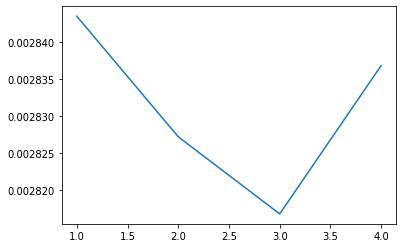

In [16]:
plt.plot(range(1, len(test_loss_list) + 1), test_loss_list)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])
tensor(5)


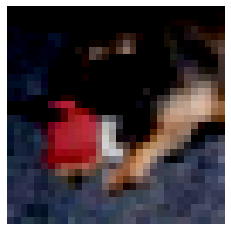

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


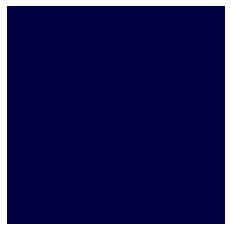

jpeg ompression rate : 3.30
AE ompression rate : 34.91


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

def imshow(img, im_name):
    img = img.detach().cpu()
    save_image(img, im_name)
    npimg = img.numpy()
    plt.axis('off')
    npimg = np.transpose(npimg, (1, 2, 0))
    #im = Image.fromarray(npimg)
    #im.save(im_name)
    #plt.imsave(im_name, npimg/)
    plt.imshow(npimg)
    plt.show()


def get_file_size_in_bytes(file_path):
   size = os.path.getsize(file_path)
   return size


for i, (im, lab) in enumerate(train_loader):
    print(im.shape)
    print(lab[0])
    imshow(im[0], '/content/image.jpeg')
    fake = model(im.to(DEVICE))
    print(fake.shape)
    imshow(fake[0], '/content/fake.jpeg')
    real_size = get_file_size_in_bytes('/content/image.jpeg')
    compressed_state=model.encoder_layers()
    jpeg_comp_rate = 3*32*32 / real_size
    #ae_comp_rate = sys.getsizeof(fake[0]) / sys.getsizeof(compressed_state(im)[0])
    ae_comp_rate = 3*32*32 / sys.getsizeof(compressed_state(im)[0])
    print('jpeg ompression rate : {:.2f}'.format(jpeg_comp_rate))
    print('AE ompression rate : {:.2f}'.format(ae_comp_rate))
    break

